In [142]:
from src.ProfileGenerator import ProfileGenerator
from src.JobGenerator import JobGenerator

from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
import json

## A

In [143]:

N = 4          # Cantidad de casos
nb_hosts = 4   # Cantidad de recursos
simulation_time = 100000 # Duración de cada episodio.

episodes = { "profiles": [None]*N, "jobs": [None]*N }

prof_gen = ProfileGenerator(max_resources=nb_hosts)

lows  = np.sort(np.random.randint(50, 80, size=4)) / 100
highs = np.array([ 0.05 if i < 0.6 else 0 for i in lows ])
mids  = 1.0 - lows - highs

for i in range(N):
    episodes["profiles"][i] = prof_gen.generate(number_of_profiles=100, low_percent=lows[i], med_percent=mids[i], high_percent=highs[i])

lows, mids, highs

(array([0.51, 0.52, 0.56, 0.74]),
 array([0.44, 0.43, 0.39, 0.26]),
 array([0.05, 0.05, 0.05, 0.  ]))

## B

### B auxs

In [145]:
def linearly_increasing_probability(t):
    return t / 3600  # Aumenta linealmente hasta 1 en una

def cyclic_poisson_probability(t, base_lambda=0.05, amplitude=0.04, period=3600):
    # Variar lambda con una función sinusoidal
    lambda_t = base_lambda + amplitude * np.sin(2 * np.pi * t / period)
    
    # Probabilidad de 0 eventos en el intervalo de tiempo t usando el lambda variante
    prob_0 = np.exp(-lambda_t)
    
    # Probabilidad de al menos 1 evento en el intervalo de tiempo t
    return 1 - prob_0

### BB

In [146]:
base_graph = nx.DiGraph()
# Añadir nodos y aristas principales
base_graph.add_edge(0, 1)
base_graph.add_edge(1, 2)
base_graph.add_edge(2, 3)
base_graph.add_edge(3, 4)

# Añadir dependencias cruzadas
base_graph.add_edge(0, 2)  # Nodo 0 también influye en el nodo 2
base_graph.add_edge(1, 3)  # Nodo 1 también influye en el nodo 3
base_graph.add_edge(2, 4)  # Nodo 2 también influye en el nodo 4

# Añadir nodos y aristas adicionales para mayor complejidad
base_graph.add_edge(0, 5)
base_graph.add_edge(5, 6)
base_graph.add_edge(6, 4)  # Nodo 6 influye en el nodo 4
base_graph.add_edge(3, 6)  # Nodo 3 también influye en el nodo 6

for i in range(N):
    episodes["jobs"][i] = JobGenerator(episodes["profiles"][i])
    # revisa el batch cada 1 hora, por 3 días
    episodes["jobs"][i].generate_variable_dag(cyclic_poisson_probability, base_graph, check_interval=40, duration=simulation_time)

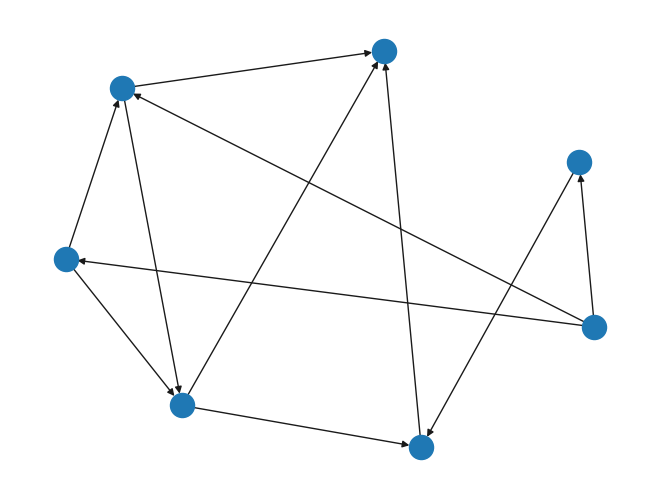

In [147]:
A = nx.nx_agraph.to_agraph(base_graph)
A.layout(prog='dot')
nx.draw(A)
plt.show()

In [148]:
for i in range(N):
    episodes["jobs"][i].generate_jobs_json(f'workload{i}')
    episodes["jobs"][i].visualize_with_subtime_annotations_dot()

/home/jpbrione/.conda/envs/bati-env/lib/python3.12/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.312674 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/jpbrione/.conda/envs/bati-env/lib/python3.12/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.307865 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/jpbrione/.conda/envs/bati-env/lib/python3.12/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.378416 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/jpbrione/.conda/envs/bati-env/lib/python3.12/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.349537 to fit

  warnings.warn(b"".join

## C

### C auxs

In [149]:
def plot_jobs_per_hour(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Extrayendo información de los trabajos
    jobs = data['jobs']
    start_times = [job['subtime'] for job in jobs]
    
    # Convertir segundos a horas
    start_times_in_hours = [time / 3600 for time in start_times]
    
    # Determinar el rango de horas
    min_hour = int(min(start_times_in_hours))
    max_hour = int(max(start_times_in_hours)) + 1  # +1 para incluir la última hora
    
    # Creando histograma
    bins = np.arange(min_hour, max_hour + 1)  # +1 para el límite final
    hist, bin_edges = np.histogram(start_times_in_hours, bins=bins)
    
    # Configuración de Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Interpolación spline cúbica para suavizar la curva
    cs = CubicSpline(bin_edges[:-1], hist, bc_type='natural')
    xs = np.linspace(min_hour, max_hour, 1000)
    
    # Dibujar la curva suavizada
    sns.lineplot(x=xs, y=cs(xs), color='b')
    
    # Configurar las marcas del eje x para que aparezcan en cada hora
    plt.xticks(bin_edges[:-1])
    # Configurar las etiquetas del eje x para que se muestren cada 4 horas
    plt.gca().set_xticklabels([f"{int(i)}" if i % 4 == 0 else "" for i in bin_edges[:-1]])
    
    plt.xlabel('Hour')
    plt.ylabel('Number of Jobs')
    plt.title('Jobs Started per Hour')
    
    plt.tight_layout()
    #plt.savefig('jobsxhour.png')

### CC

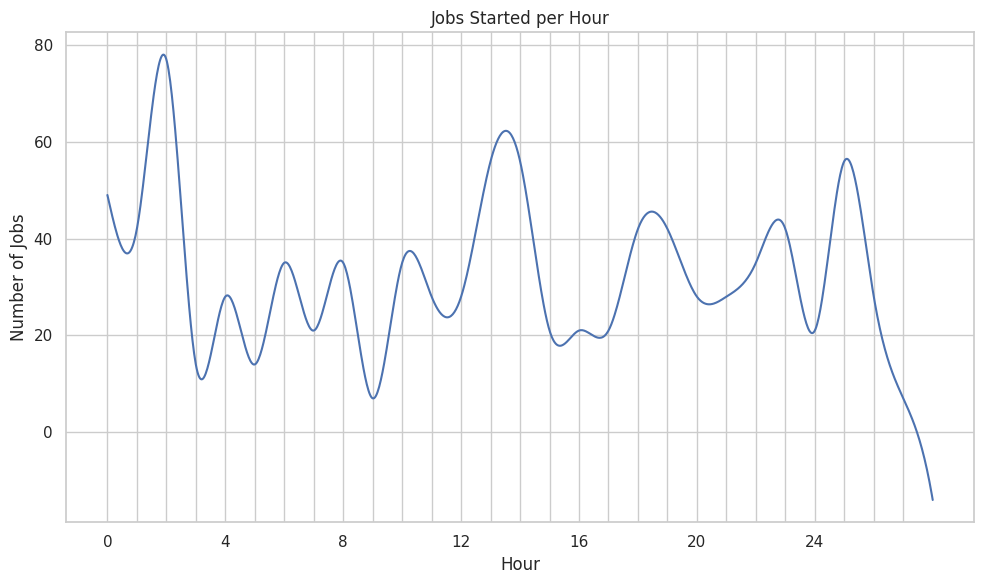

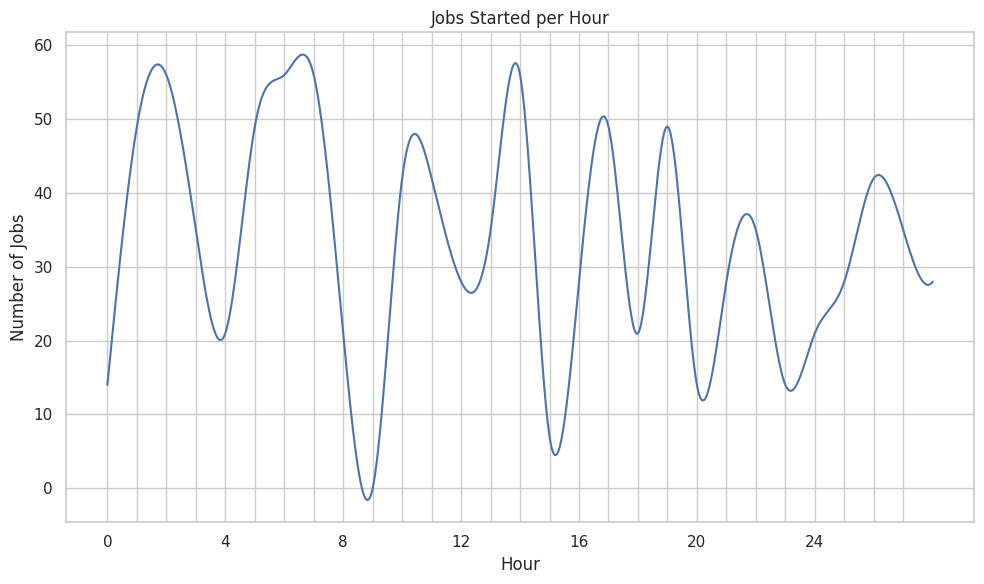

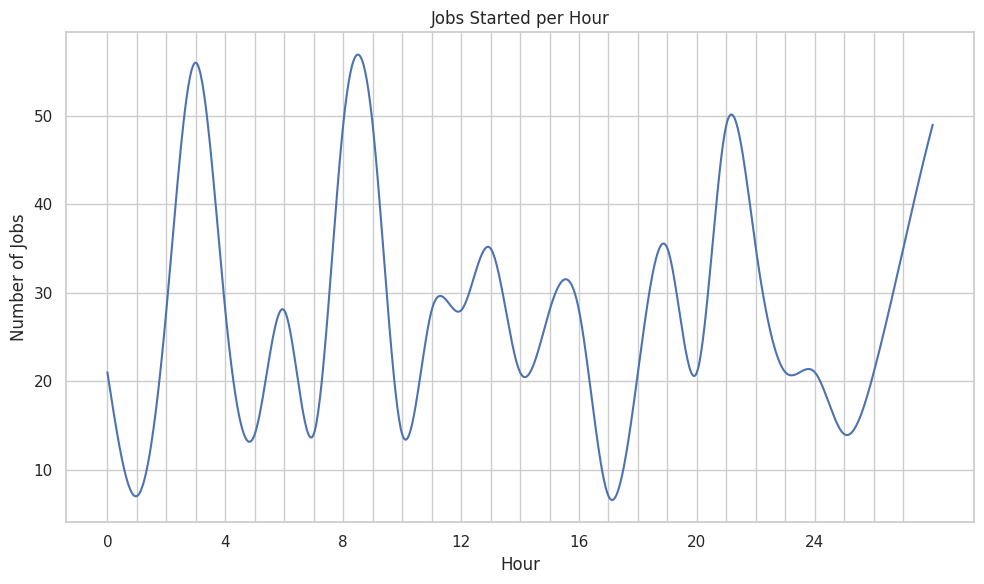

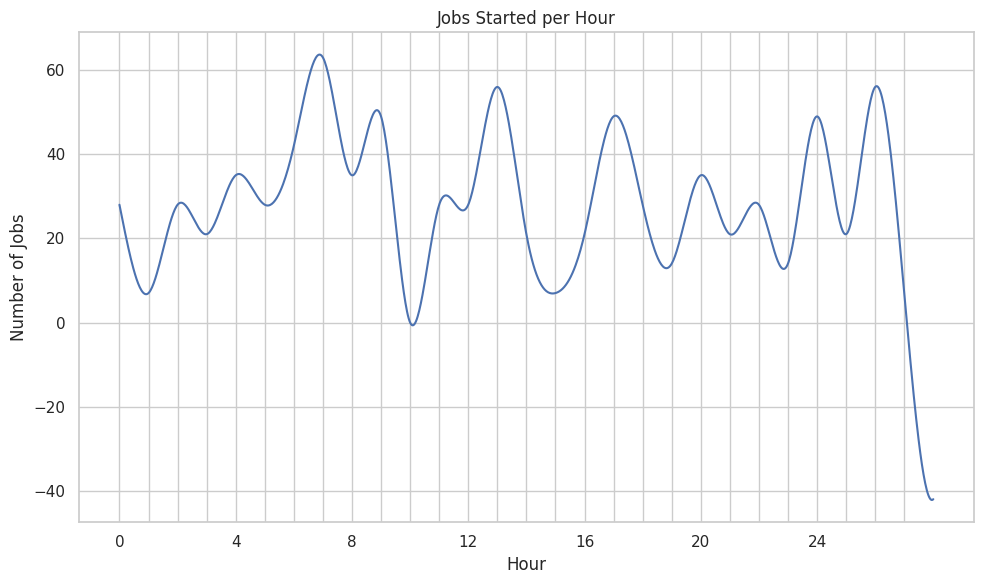

In [150]:
for i in range(N):
    plot_jobs_per_hour(f"workload{i}.json")

#plt.show()

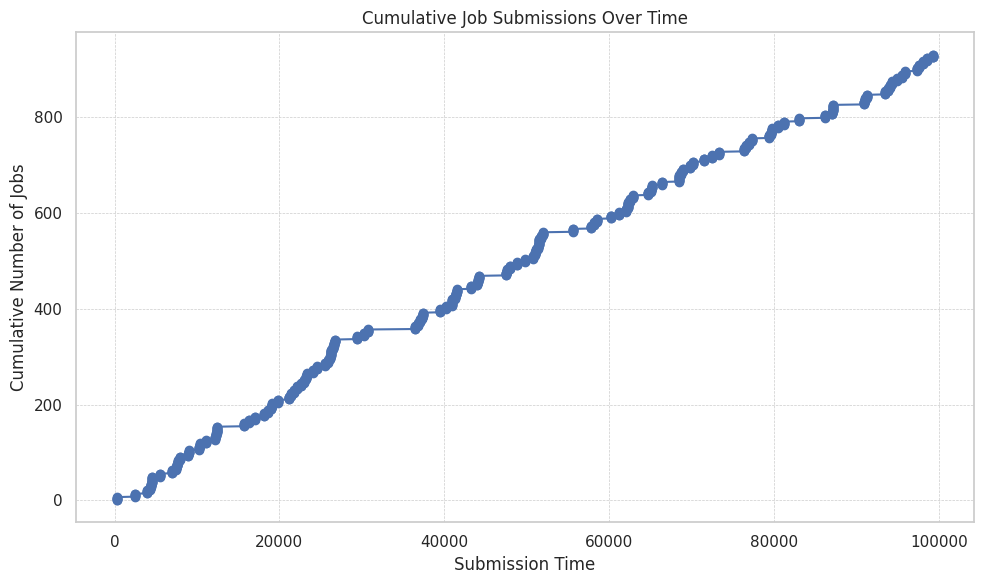

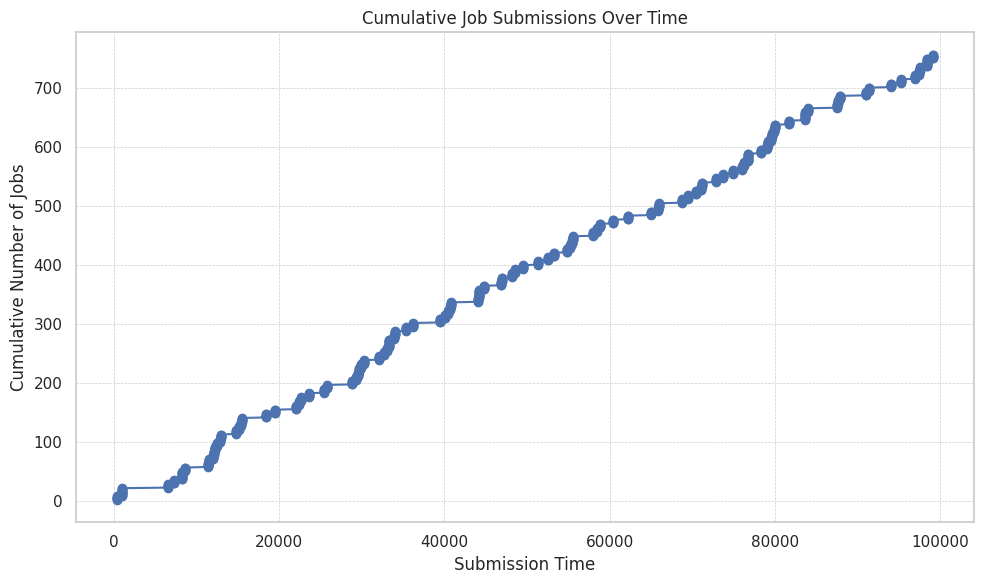

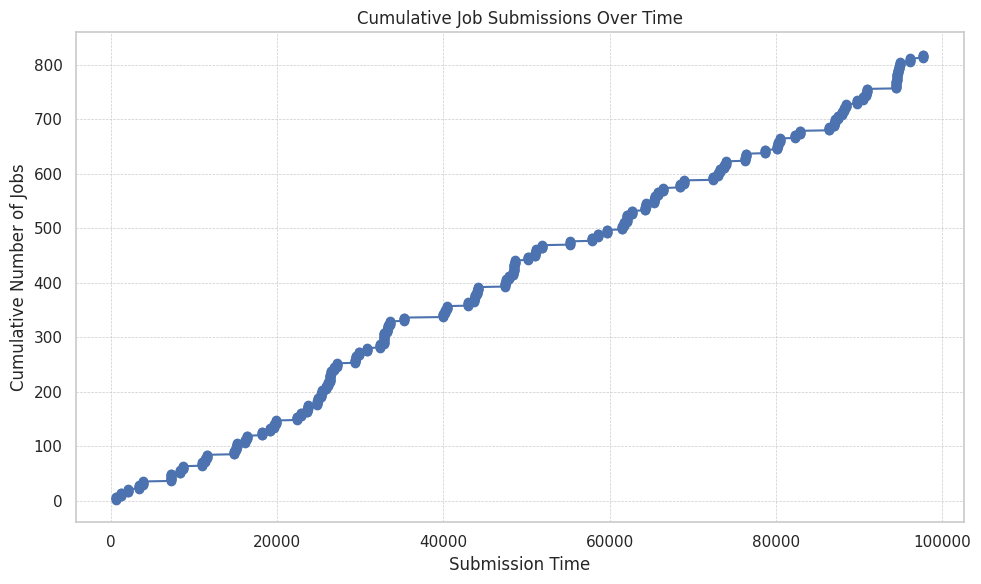

FileNotFoundError: [Errno 2] No such file or directory: 'workload4.json'

In [151]:
workloads_data = []
subtimes = []

for i in range(N):
    with open(f"workload{i+1}.json", "r") as file:
        workloads_data.append(json.load(file))

    # Extract subtimes
    subtimes = [job["subtime"] for job in workloads_data[i]["jobs"]]

    # Sorting subtimes
    sorted_subtimes = np.sort(subtimes)

    # Create a cumulative count of jobs for each unique subtime
    cumulative_counts = np.arange(1, len(sorted_subtimes) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_subtimes, cumulative_counts, marker='o', linestyle='-', color='b')
    plt.title("Cumulative Job Submissions Over Time")
    plt.xlabel("Submission Time")
    plt.ylabel("Cumulative Number of Jobs")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()